In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
jobs_df = pd.read_csv('jobs.csv')
jobs_df.head()

,Job ID,Job Salary,Job Experience Required,Key Skills,Role Category,Functional Area,Industry,Job Title
0,0,Not Disclosed by Recruiter,5 - 10 yrs,Media Planning| Digital Media,Advertising,"Marketing , Advertising , MR , PR , Media Plan...","Advertising, PR, MR, Event Management",Media Planning Executive/Manager
1,1,Not Disclosed by Recruiter,2 - 5 yrs,pre sales| closing| software knowledge| clien...,Retail Sales,"Sales , Retail , Business Development","IT-Software, Software Services",Sales Executive/Officer
2,2,Not Disclosed by Recruiter,0 - 1 yrs,Computer science| Fabrication| Quality check|...,R&D,"Engineering Design , R&D","Recruitment, Staffing",R&D Executive
3,3,"2,00,000 - 4,00,000 PA.",0 - 5 yrs,Technical Support,Admin/Maintenance/Security/Datawarehousing,"IT Software - Application Programming , Mainte...","IT-Software, Software Services",Technical Support Engineer
4,4,Not Disclosed by Recruiter,2 - 5 yrs,manual testing| test engineering| test cases|...,Programming & Design,IT Software - QA & Testing,"IT-Software, Software Services",Testing Engineer


In [4]:
resumes = [
    "Experienced data scientist with expertise in Python, machine learning, and data visualization.",
    "Software engineer with proficiency in Java, C++, and cloud computing.",
    "Fresh graduate with knowledge in computer science, fabrication, and quality check.",
    "Technical support specialist with skills in troubleshooting and user support.",
    "Software tester experienced in manual testing, test engineering, and test cases.",
    # Add more resumes as needed
]

resumes_df = pd.DataFrame(resumes, columns=['Resume'])

skills_list = [
    'Python', 'machine learning', 'data visualization', 'Java', 'C++', 'cloud computing',
    'computer science', 'fabrication', 'quality check', 'technical support',
    'manual testing', 'test engineering', 'test cases', 'troubleshooting', 'user support'
]

def extract_skills(text, skills):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    extracted_skills = [skill for skill in skills if skill.lower() in tokens]
    return extracted_skills

resumes_df['Skills'] = resumes_df['Resume'].apply(lambda x: extract_skills(x, skills_list))
resumes_df.to_csv('extracted_skills.csv', index=False)

In [5]:
df = pd.read_csv('extracted_skills.csv')
df.head()

,Resume,Skills
0,Experienced data scientist with expertise in P...,['Python']
1,"Software engineer with proficiency in Java, C+...","['Java', 'C++']"
2,Fresh graduate with knowledge in computer scie...,['fabrication']
3,Technical support specialist with skills in tr...,['troubleshooting']
4,"Software tester experienced in manual testing,...",[]


In [6]:
# Collaborative Filtering
interaction_data = {
    'Resume_ID': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4],
    'Job_ID': [0, 2, 1, 3, 2, 4, 3, 0, 4, 1],
    'Interaction': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}

interaction_df = pd.DataFrame(interaction_data)
user_item_matrix = interaction_df.pivot(index='Resume_ID', columns='Job_ID', values='Interaction').fillna(0)

user_similarity = cosine_similarity(user_item_matrix)

def get_collaborative_recommendations(user_id, user_similarity, top_n=3):
    similar_users = list(enumerate(user_similarity[user_id]))
    similar_users = sorted(similar_users, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_jobs = set()
    for user, score in similar_users:
        user_jobs = set(interaction_df[interaction_df['Resume_ID'] == user]['Job_ID'])
        recommended_jobs = recommended_jobs.union(user_jobs)
    return recommended_jobs

collab_recommendations = get_collaborative_recommendations(0, user_similarity)
print("Collaborative Filtering Recommendations for Resume 0:", collab_recommendations)

Collaborative Filtering Recommendations for Resume 0: {0, 1, 2, 3, 4}


In [7]:

# Content-Based Filtering
jobs_df['Combined'] = jobs_df['Key Skills'] + ' ' + jobs_df['Role Category'] + ' ' + jobs_df['Functional Area'] + ' ' + jobs_df['Industry'] + ' ' + jobs_df['Job Title']
resumes_df['All_Skills'] = resumes_df['Skills'].apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
job_tfidf = tfidf_vectorizer.fit_transform(jobs_df['Combined'])
resume_tfidf = tfidf_vectorizer.transform(resumes_df['All_Skills'])

cosine_similarities = cosine_similarity(resume_tfidf, job_tfidf)

def get_content_based_recommendations(resume_id, cosine_similarities, top_n=3):
    sim_scores = list(enumerate(cosine_similarities[resume_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_n]
    recommended_jobs = [job[0] for job in sim_scores]
    return recommended_jobs

content_recommendations = get_content_based_recommendations(0, cosine_similarities)
print("Content-Based Filtering Recommendations for Resume 0:", content_recommendations)

Content-Based Filtering Recommendations for Resume 0: [17508, 13298, 18874]


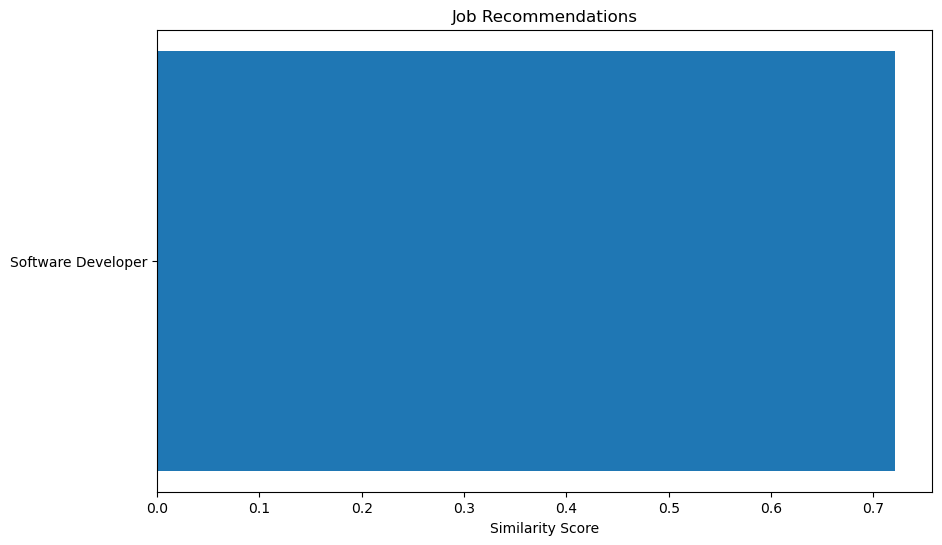

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
# Visualization Function
def visualize_recommendations(resume_id, cosine_similarities, jobs_df, top_n=3):
    recommended_jobs = get_content_based_recommendations(resume_id, cosine_similarities, top_n)
    recommended_jobs_df = jobs_df.iloc[recommended_jobs]
    
    plt.figure(figsize=(10, 6))
    plt.barh(recommended_jobs_df['Job Title'], cosine_similarities[resume_id][recommended_jobs])
    plt.xlabel('Similarity Score')
    plt.title('Job Recommendations')
    plt.gca().invert_yaxis()  # Highest scores at the top
    plt.show()

# Visualize recommendations for resume with ID 0
visualize_recommendations(0, cosine_similarities, jobs_df)

In [19]:
pip install dash pandas plotly

Note: you may need to restart the kernel to use updated packages.


In [21]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.graph_objs as go

# Load the data
jobs_df = pd.read_csv('jobs.csv')

# Define the specific skills
specific_skills = "Python SQL Power BI"

# Combine all relevant job details into a single string for each job
jobs_df['Combined'] = jobs_df['Key Skills'] + ' ' + jobs_df['Role Category'] + ' ' + jobs_df['Functional Area'] + ' ' + jobs_df['Industry'] + ' ' + jobs_df['Job Title']

# Vectorize job descriptions
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
job_tfidf = tfidf_vectorizer.fit_transform(jobs_df['Combined'])

# Vectorize the specific skills
skills_tfidf = tfidf_vectorizer.transform([specific_skills])

# Compute cosine similarity between specific skills and job descriptions
cosine_similarities = cosine_similarity(skills_tfidf, job_tfidf).flatten()

# Get top job recommendations
content_recommendations = get_content_based_recommendations(cosine_similarities, top_n=3)
recommended_jobs_df = jobs_df.iloc[content_recommendations]
recommended_jobs_df = recommended_jobs_df[['Job Title', 'Job Experience Required', 'Key Skills', 'Role Category', 'Functional Area', 'Industry']]  # Modify as needed based on actual column names

# Create Dash app
app = dash.Dash(__name__)

# Define app layout
app.layout = html.Div([
    html.H1("Job Recommendations Based on Skills"),
    html.Div([
        dcc.Graph(
            id='job-recommendations-table',
            figure={
                'data': [
                    go.Table(
                        header=dict(values=recommended_jobs_df.columns.tolist(),
                                    fill_color='lightgrey',
                                    align='center',
                                    font=dict(size=14, color='black')),
                        cells=dict(values=[recommended_jobs_df[col] for col in recommended_jobs_df.columns],
                                   fill_color='white',
                                   align='center',
                                   font=dict(size=12, color='black')))
                ],
                'layout': dict(height=500, margin=dict(l=20, r=20, t=30, b=20))
            }
        )
    ])
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True,port=8051)


In [24]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px

# Load the data
jobs_df = pd.read_csv('jobs.csv')

# Define the specific skills
specific_skills = "Python SQL Power BI"

# Combine all relevant job details into a single string for each job
jobs_df['Combined'] = jobs_df['Key Skills'] + ' ' + jobs_df['Role Category'] + ' ' + jobs_df['Functional Area'] + ' ' + jobs_df['Industry'] + ' ' + jobs_df['Job Title']

# Vectorize job descriptions
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
job_tfidf = tfidf_vectorizer.fit_transform(jobs_df['Combined'])

# Vectorize the specific skills
skills_tfidf = tfidf_vectorizer.transform([specific_skills])

# Compute cosine similarity between specific skills and job descriptions
cosine_similarities = cosine_similarity(skills_tfidf, job_tfidf).flatten()

# Get top job recommendations
content_recommendations = get_content_based_recommendations(cosine_similarities, top_n=3)
recommended_jobs_df = jobs_df.iloc[content_recommendations]

# Create Dash app
app = dash.Dash(__name__)

# Define app layout
app.layout = html.Div([
    html.H1("Urcareer"),
    dcc.Graph(id='animated-jobs-chart'),
    dcc.Interval(
        id='interval-component',
        interval=2000,  # Update every 2 seconds
        n_intervals=0
    )
])

# Define callback to update the animated chart
@app.callback(
    dash.dependencies.Output('animated-jobs-chart', 'figure'),
    [dash.dependencies.Input('interval-component', 'n_intervals')]
)
def update_animated_chart(n):
    # Get current recommended job
    current_job = recommended_jobs_df.iloc[n % len(recommended_jobs_df)]

    # Create bar chart figure
    fig = px.bar(
        x=[current_job['Job Title']],
        y=[current_job['Job Salary']],
        labels={'x': 'Job Title', 'y': 'Salary'},
        title=f"Predicted Job: {current_job['Job Title']} - Salary: {current_job['Job Salary']}"
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8053)
